A Python script for developing the camera calibration and processing tools, using some iPhone test images.

Process:
- load in the images for the different views.
- for each view, identify the calibration target
- get the point coordinates
- get the image coordinates
- stack these together, and enter into the opencv camera calibration function.

In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

%matplotlib inline

# Import the images

In [2]:
test_dir = '/Users/sci/Desktop/iphone_calibration_test'
# open images in test_dir
images = [cv.imread(os.path.join(test_dir, f)) for f in os.listdir(test_dir) if f.endswith('.tif')]

# Find the calibration target in each image

error!


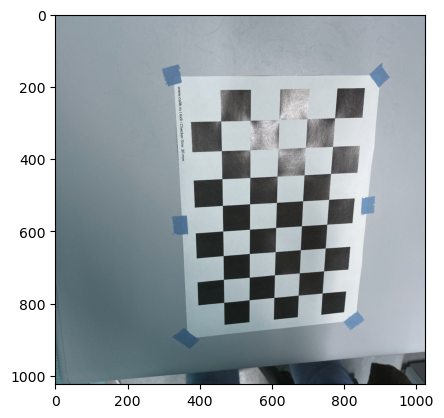

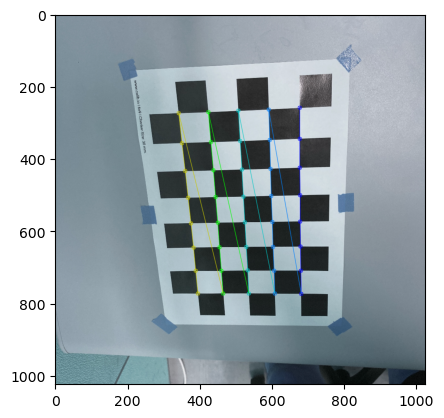

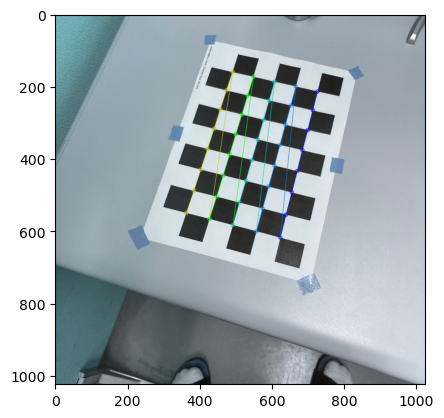

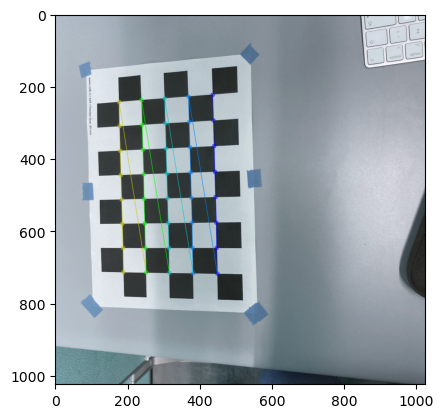

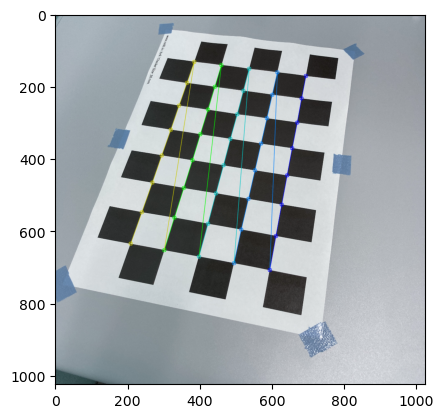

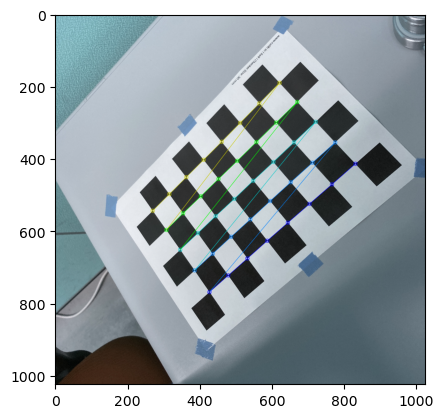

error!


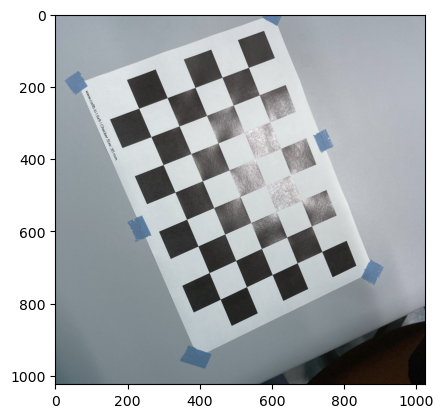

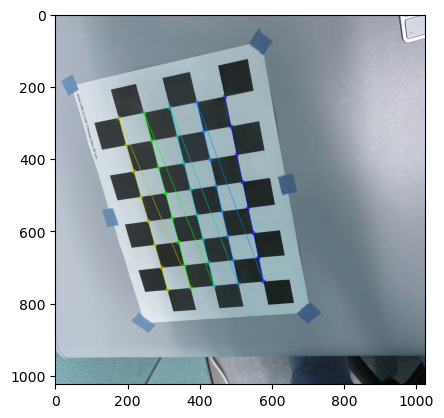

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
cb_rows = 8
cb_cols = 5
objp = np.zeros((cb_rows*cb_cols,3), np.float32)
objp[:,:2] = np.mgrid[0:cb_rows,0:cb_cols].T.reshape(-1,2)
corners2lst = []
imagelst = []

for image in images:
     # Find the chess board corners
    image = cv.resize(image, (1024,1024))
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)    
    # plt.imshow(gray)    
    # plt.show()
    ret, corners = cv.findChessboardCorners(gray, (cb_rows,cb_cols), None, cv.CALIB_CB_ADAPTIVE_THRESH)    
    # If found, add object points, image points (after refining them)
    if ret != True:
        print('error!')
        plt.imshow(image)
        plt.show()
    else:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        corners2lst.append(corners2)
        imgpoints.append(corners2)
        imagelst.append(gray)
        # Draw and display the corners
        cv.drawChessboardCorners(image, (cb_rows,cb_cols), corners2, ret)
        plt.imshow(image)
        plt.show()

2 of the iamges failed, on inspection this is likely due to overexposure of some of the patches due to specular reflection. We could treat this with thresholding, but for now we have a sufficient number of points to use, that will ocntinue to process here to find the camera calibration.

# Stack the results and process with Calibration Function

In [4]:
gray.shape[::-1]

(1024, 1024)

In [5]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [6]:
ret

0.2054767839143963

In [7]:
mtx

array([[1.09123740e+03, 0.00000000e+00, 5.27671307e+02],
       [0.00000000e+00, 1.09021826e+03, 5.05326732e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [8]:
dist

array([[ 2.56097062e-01, -1.58034785e+00,  1.12944572e-03,
         1.73535152e-03,  3.19974499e+00]])

In [9]:
rvecs

(array([[ 0.33903848],
        [-0.20207329],
        [ 1.51465217]]),
 array([[-0.21130877],
        [ 0.29218662],
        [ 1.81814082]]),
 array([[0.17321703],
        [0.15631185],
        [1.54059594]]),
 array([[-0.29649595],
        [ 0.43353865],
        [ 1.73139163]]),
 array([[0.44628331],
        [0.24247358],
        [2.38833784]]),
 array([[ 0.39337446],
        [-0.0584919 ],
        [ 1.38236409]]))

In [10]:
tvecs

(array([[ 1.74459102],
        [-2.87339405],
        [12.900463  ]]),
 array([[ 3.23930261],
        [-4.77546403],
        [18.0888432 ]]),
 array([[-1.28990585],
        [-3.9832187 ],
        [15.51100539]]),
 array([[ 2.07058783],
        [-4.17830581],
        [13.78692044]]),
 array([[ 3.59017998],
        [-1.0815141 ],
        [13.09514672]]),
 array([[-0.70413097],
        [-3.35886846],
        [13.34346311]]))

We can verify the matrices by projecting points in the world space.

Here we do this for the first image that we solved for correctly (image[1])

In [11]:
def draw(img, corners, imgpts):
 corner = tuple(corners[0].ravel().astype(int))
 img = cv.line(img, corner, tuple(imgpts[0].ravel().astype(int)), (255,0,0), 5)
 img = cv.line(img, corner, tuple(imgpts[1].ravel().astype(int)), (0,255,0), 5)
 img = cv.line(img, corner, tuple(imgpts[2].ravel().astype(int)), (0,0,255), 5)
 return img

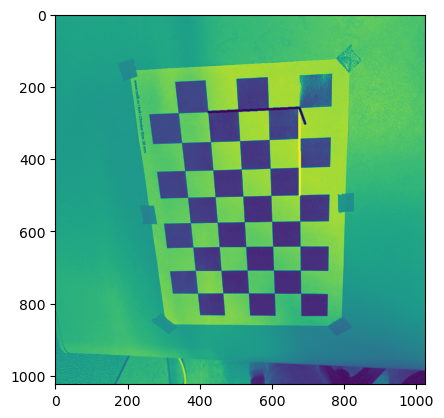

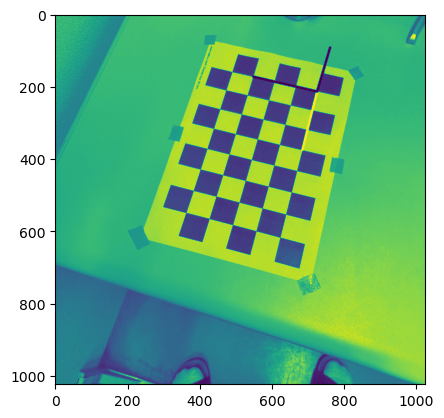

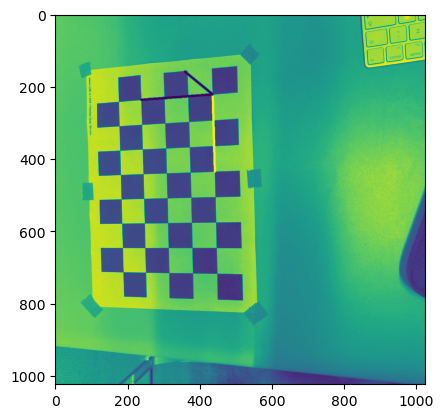

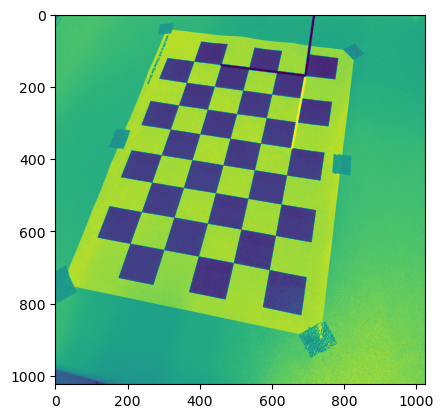

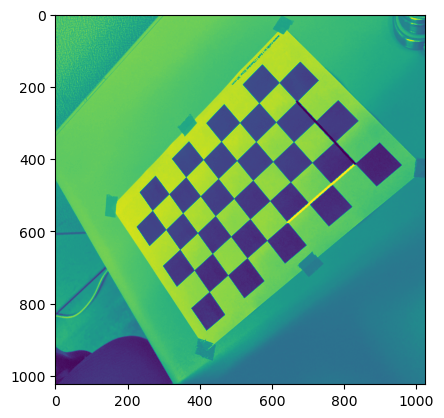

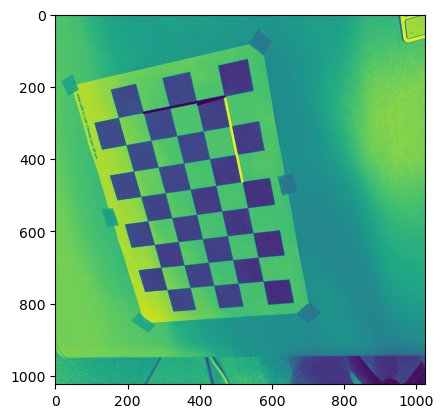

In [12]:
axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3) 
for n, image in enumerate(imagelst):
    imgpts, jac = cv.projectPoints(axis, rvecs[n], tvecs[n], mtx, dist)
    image = cv.resize(image, (1024,1024))
    img = draw(image,corners2lst[n],imgpts)
    plt.imshow(img)
    plt.show()

This confirms the success of the camera calibration, in terms of the rotation and translation matrices found for each target image.

So this shows that we will need to find rotation and translation vectors for the sample image plane.

The next question is how do we find a depth image, or 3D image, from these calibration results?

# Eipolar Lines

We are going take the first 2 images here and draw the epipolar lines for each of these, using the points already found for the checkerboard.

As these contain 40 points each, we should have not problem finding the Fundamental matrix.

In [13]:
a = 1
b = 5

img1 = imagelst[a]
# img1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img2 = imagelst[b]
# img2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
pts1 = corners2lst[a]
pts2 = corners2lst[b]

In [14]:
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

In [15]:
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [16]:
# checking the Fundamental Matrix for x1^TFx2 = 0
for i in range(len(pts1)):
    pt1 = np.array([[pts1[i][0][0]], [pts1[i][0][1]], [1]])
    pt2 = np.array([[pts2[i][0][0], pts2[i][0][1], 1]])

    print(f"Fundamental matrix error check: {np.dot(np.dot(pt2,F),pt1)}")

Fundamental matrix error check: [[3.37920312e-05]]
Fundamental matrix error check: [[-3.63979201e-05]]
Fundamental matrix error check: [[-2.91433544e-16]]
Fundamental matrix error check: [[-2.77555756e-16]]
Fundamental matrix error check: [[-2.2137838e-05]]
Fundamental matrix error check: [[5.70072222e-05]]
Fundamental matrix error check: [[0.00029376]]
Fundamental matrix error check: [[-2.22044605e-16]]
Fundamental matrix error check: [[8.17263642e-05]]
Fundamental matrix error check: [[-3.73920783e-05]]
Fundamental matrix error check: [[-1.47837183e-05]]
Fundamental matrix error check: [[-8.89549037e-05]]
Fundamental matrix error check: [[-5.43479139e-05]]
Fundamental matrix error check: [[-2.22044605e-16]]
Fundamental matrix error check: [[-1.66533454e-16]]
Fundamental matrix error check: [[-3.8251912e-05]]
Fundamental matrix error check: [[0.0001204]]
Fundamental matrix error check: [[-3.97823735e-05]]
Fundamental matrix error check: [[-4.20552007e-05]]
Fundamental matrix error che

we use the following function, lifted from the OpenCV tutorial, to draw the lines:

In [17]:
def drawlines(img1,img2,lines,pts1,pts2):
 ''' img1 - image on which we draw the epilines for the points in img2
 lines - corresponding epilines '''
 r,c = img1.shape
 img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
 img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
 for r,pt1,pt2 in zip(lines,pts1,pts2):
    color = (0,255,0) #tuple(np.random.randint(0,255,3).tolist())
    x0,y0 = map(int, [0, -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
    img1 = cv.circle(img1,tuple(pt1.flatten().astype(int)),5,color,-1)
    img2 = cv.circle(img2,tuple(pt2.flatten().astype(int)),5,color,-1)
 return img1,img2

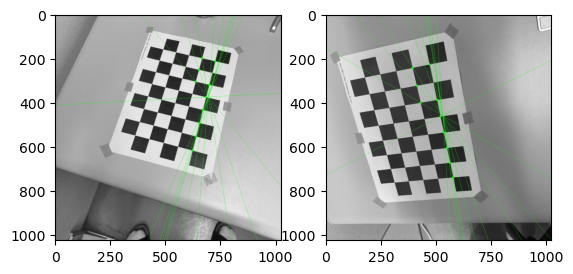

(<Axes: >, <matplotlib.image.AxesImage at 0x12a1ba3b0>)

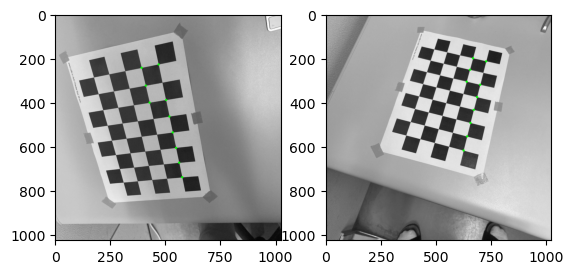

In [18]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2)[0:10],1,F.T)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2)[0:10], 2,F.T)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()
plt.subplot(121),plt.imshow(img6)
plt.subplot(122),plt.imshow(img4)
# plt.show()